In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

#압축 파일 경로
zip_path = "/content/drive/MyDrive/흑백 이미지 컬러 복원/datafinal.zip"
#압축 해제 경로
extract_path = "/content/drive/MyDrive/흑백 이미지 컬러 복원"

#압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print("압축 해제 완료!")

#압축 해제된 파일 목록 확인
for root, dirs, files in os.walk(extract_path):
    for file in files:
        print(os.path.join(root, file))

압축 해제 완료!
/content/drive/MyDrive/흑백 이미지 컬러 복원/흑백 이미지 컬러 복원 색상화.ipynb
/content/drive/MyDrive/흑백 이미지 컬러 복원/datafinal.zip
/content/drive/MyDrive/흑백 이미지 컬러 복원/color/0.jpg
/content/drive/MyDrive/흑백 이미지 컬러 복원/color/1.jpg
/content/drive/MyDrive/흑백 이미지 컬러 복원/color/10.jpg
/content/drive/MyDrive/흑백 이미지 컬러 복원/color/100.jpg
/content/drive/MyDrive/흑백 이미지 컬러 복원/color/1000.jpg
/content/drive/MyDrive/흑백 이미지 컬러 복원/color/1001.jpg
/content/drive/MyDrive/흑백 이미지 컬러 복원/color/1002.jpg
/content/drive/MyDrive/흑백 이미지 컬러 복원/color/1003.jpg
/content/drive/MyDrive/흑백 이미지 컬러 복원/color/1004.jpg
/content/drive/MyDrive/흑백 이미지 컬러 복원/color/1005.jpg
/content/drive/MyDrive/흑백 이미지 컬러 복원/color/1006.jpg
/content/drive/MyDrive/흑백 이미지 컬러 복원/color/1007.jpg
/content/drive/MyDrive/흑백 이미지 컬러 복원/color/1008.jp

In [ ]:
import random
import numpy as np
import os
import torch
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import cv2
import zipfile

# 시드 설정 함수 (멀티 GPU 및 재현성 강화 포함)
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [ ]:
# 하이퍼파라미터 설정
CFG = {
    'EPOCHS': 10,
    'LEARNING_RATE': 0.0005,
    'BATCH_SIZE': 16,
    'SEED': 42
}

# 시드 고정 실행
seed_everything(CFG['SEED'])

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED'])

In [ ]:
# 커스텀 데이터셋 정의
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, gray_dir, color_dir, transform=None):
        self.gray_dir = gray_dir
        self.color_dir = color_dir
        self.gray_files = sorted(os.listdir(gray_dir))
        self.color_files = sorted(os.listdir(color_dir))
        self.transform = transform

    def __len__(self):
        return len(self.gray_files)

    def __getitem__(self, idx):
        gray_img_path = os.path.join(self.gray_dir, self.gray_files[idx])
        color_img_path = os.path.join(self.color_dir, self.color_files[idx])

        try:
            gray_img = Image.open(gray_img_path).convert("L")
            color_img = Image.open(color_img_path).convert("RGB")
        except Exception as e:
            print(f"이미지를 열 수 없습니다: {gray_img_path}, {color_img_path}, 오류: {e}")
            return self.__getitem__((idx + 1) % len(self.gray_files))

        if self.transform:
            gray_img = self.transform(gray_img)
            color_img = self.transform(color_img)

        return {'A': gray_img, 'B': color_img}

In [ ]:
import torchvision.transforms as transforms

# 전처리 정의
gray_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# 데이터 경로 설정
gray_dir = '/content/drive/MyDrive/흑백 이미지 컬러 복원/gray'
color_dir = '/content/drive/MyDrive/흑백 이미지 컬러 복원/color'
test_dir = '/content/drive/MyDrive/흑백 이미지 컬러 복원/test'

# 데이터 로더 정의
dataset = CustomDataset(gray_dir=gray_dir, color_dir=color_dir, transform=gray_transform)
dataloader = DataLoader(dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=1)

In [ ]:
# 공통 전처리 정의
gray_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
dataset = CustomDataset(gray_dir=gray_dir, color_dir=color_dir, transform=gray_transform)

In [ ]:
# U-Net Generator(G) 정의
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(UNetGenerator, self).__init__()

        def down_block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def up_block(in_feat, out_feat, dropout=0.0):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, kernel_size=4, stride=2, padding=1),
                      nn.BatchNorm2d(out_feat),
                      nn.ReLU(inplace=True)]
            if dropout:
                layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        self.down1 = down_block(in_channels, 64, normalize=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)
        self.down5 = down_block(512, 512)
        self.down6 = down_block(512, 512)
        self.down7 = down_block(512, 512)
        self.down8 = down_block(512, 512, normalize=False)

        self.up1 = up_block(512, 512, dropout=0.5)
        self.up2 = up_block(1024, 512, dropout=0.5)
        self.up3 = up_block(1024, 512, dropout=0.5)
        self.up4 = up_block(1024, 512)
        self.up5 = up_block(1024, 256)
        self.up6 = up_block(512, 128)
        self.up7 = up_block(256, 64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        u8 = self.up8(torch.cat([u7, d1], 1))

        return u8

# PatchGAN Discriminator(D) 정의
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=4):  # channel 1(gray) + channel 3(color)
        super(PatchGANDiscriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            discriminator_block(in_channels, 64, normalization=False),
            discriminator_block(64, 128),
            discriminator_block(128, 256),
            discriminator_block(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, padding=1)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)

dataloader = DataLoader(
    dataset,
    batch_size=CFG['BATCH_SIZE'],
    shuffle=True,
    num_workers=0,
    worker_init_fn=seed_worker,
    generator=g
)

In [ ]:
# 테스트 이미지 전처리 함수
def load_image(image_path, transform):
    image = Image.open(image_path).convert("L")
    image = transform(image).unsqueeze(0)
    return image
print("Saved all images")

Saved all images


In [ ]:
# 가중치 초기화 함수
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
# 모델 초기화 및 설정
generator = UNetGenerator().to(device)
discriminator = PatchGANDiscriminator().to(device)
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

criterion_GAN = nn.MSELoss()
criterion_pixelwise = nn.L1Loss()

optimizer_G = optim.Adam(generator.parameters(), lr=CFG['LEARNING_RATE'])
optimizer_D = optim.Adam(discriminator.parameters(), lr=CFG['LEARNING_RATE'])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 187MB/s]


[Epoch 1/50] [Batch 0/94] [G: 15.2061 (GAN: 0.5943, pixel: 0.4727, perceptual: 0.0863)] [D: 0.0000]
[Epoch 1/50] [Batch 1/94] [G: 13.8905 (GAN: 0.5714, pixel: 0.4318, perceptual: 0.0731)] [D: 0.0000]
[Epoch 1/50] [Batch 2/94] [G: 14.2788 (GAN: 0.5519, pixel: 0.4439, perceptual: 0.0821)] [D: 0.0000]
[Epoch 1/50] [Batch 3/94] [G: 14.4788 (GAN: 0.5347, pixel: 0.4518, perceptual: 0.0781)] [D: 0.0000]
[Epoch 1/50] [Batch 4/94] [G: 13.6502 (GAN: 0.5586, pixel: 0.4236, perceptual: 0.0764)] [D: 0.0000]
[Epoch 1/50] [Batch 5/94] [G: 13.0862 (GAN: 0.5265, pixel: 0.4060, perceptual: 0.0757)] [D: 0.0000]
[Epoch 1/50] [Batch 6/94] [G: 12.5169 (GAN: 0.5361, pixel: 0.3850, perceptual: 0.0865)] [D: 0.0000]
[Epoch 1/50] [Batch 7/94] [G: 14.2498 (GAN: 0.5148, pixel: 0.4445, perceptual: 0.0799)] [D: 0.0000]
[Epoch 1/50] [Batch 8/94] [G: 11.7248 (GAN: 0.5098, pixel: 0.3601, perceptual: 0.0822)] [D: 0.0000]
[Epoch 1/50] [Batch 9/94] [G: 10.9779 (GAN: 0.5048, pixel: 0.3360, perceptual: 0.0784)] [D: 0.0000]


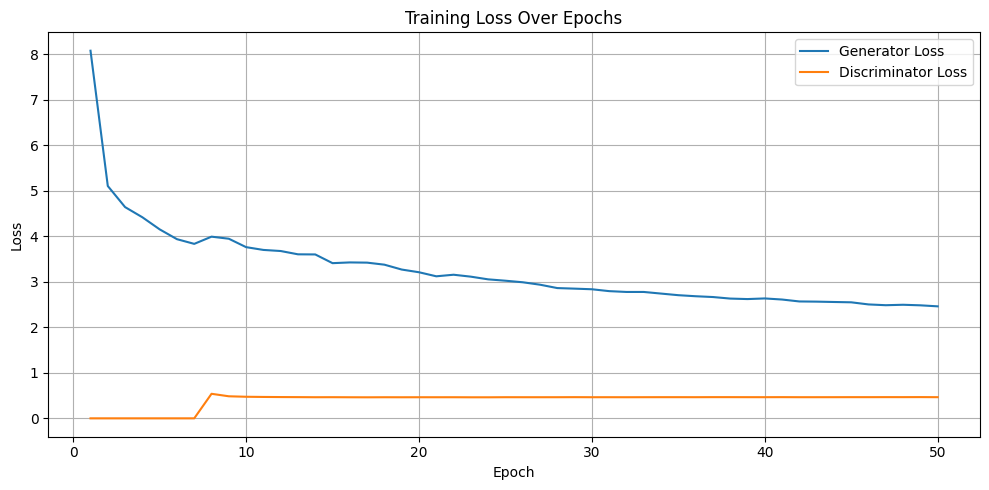

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_save_dir = "./saved_models"
os.makedirs(model_save_dir, exist_ok=True)

CFG = {
    'EPOCHS': 50,
    'PATIENCE': 10,
    'LEARNING_RATE_G': 0.00005,
    'LEARNING_RATE_D': 0.00005,
    'BATCH_SIZE': 16,
    'SEED': 42
}

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_pixelwise = nn.L1Loss()

# VGG 기반 perceptual loss
vgg = models.vgg19(pretrained=True).features[:36].to(device).eval()
for param in vgg.parameters():
    param.requires_grad = False

def perceptual_loss(fake, real):
    return F.l1_loss(vgg(fake), vgg(real))

optimizer_G = torch.optim.Adam(generator.parameters(), lr=CFG['LEARNING_RATE_G'], betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=CFG['LEARNING_RATE_D'], betas=(0.5, 0.999))
scheduler_G = ReduceLROnPlateau(optimizer_G, mode='min', factor=0.5, patience=3)
scheduler_D = ReduceLROnPlateau(optimizer_D, mode='min', factor=0.5, patience=3)

lambda_pixel = 30
lambda_perceptual = 5.0
best_loss = float("inf")
patience_counter = 0

g_losses = []
d_losses = []

for epoch in range(1, CFG['EPOCHS'] + 1):
    generator.train()
    discriminator.train()

    running_loss_G = 0.0
    running_loss_D = 0.0

    for i, batch in enumerate(dataloader):
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        # Train Generator

        optimizer_G.zero_grad()
        fake_B = generator(real_A)
        pred_fake = discriminator(real_A, fake_B)

        valid = torch.empty_like(pred_fake).uniform_(0.8, 1.0).to(device)

        loss_GAN = criterion_GAN(pred_fake, valid)
        loss_pixel = criterion_pixelwise(fake_B, real_B)
        loss_percept = perceptual_loss(fake_B, real_B)
        loss_G = loss_GAN + lambda_pixel * loss_pixel + lambda_perceptual * loss_percept
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminator

        if epoch >= 8 and i % 3 == 0:
            optimizer_D.zero_grad()
            pred_real = discriminator(real_A, real_B)
            real_valid = torch.empty_like(pred_real).uniform_(0.8, 1.0).to(device)
            loss_real = criterion_GAN(pred_real, real_valid)

            pred_fake = discriminator(real_A, fake_B.detach())
            fake_valid = torch.empty_like(pred_fake).uniform_(0.0, 0.2).to(device)
            loss_fake = criterion_GAN(pred_fake, fake_valid)

            loss_D = 0.5 * (loss_real + loss_fake)
            loss_D.backward()
            optimizer_D.step()
        else:
            loss_D = torch.tensor(0.0)

        running_loss_G += loss_G.item()
        running_loss_D += loss_D.item()

        print(f"[Epoch {epoch}/{CFG['EPOCHS']}] [Batch {i}/{len(dataloader)}] "
              f"[G: {loss_G.item():.4f} (GAN: {loss_GAN.item():.4f}, pixel: {loss_pixel.item():.4f}, perceptual: {loss_percept.item():.4f})] "
              f"[D: {loss_D.item():.4f}]")

    # 평균 손실 저장

    epoch_loss_G = running_loss_G / len(dataloader)
    epoch_loss_D = running_loss_D / (len(dataloader) // 2 + 1)
    g_losses.append(epoch_loss_G)
    d_losses.append(epoch_loss_D)

    scheduler_G.step(epoch_loss_G)
    scheduler_D.step(epoch_loss_D)

    if epoch_loss_G < best_loss:
        best_loss = epoch_loss_G
        patience_counter = 0
        torch.save(generator.state_dict(), os.path.join(model_save_dir, "best_generator.pth"))
        torch.save(discriminator.state_dict(), os.path.join(model_save_dir, "best_discriminator.pth"))
        print(f"Best model saved at epoch {epoch} (G loss: {best_loss:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s)")

    if patience_counter >= CFG['PATIENCE']:
        print(f"Early stopping triggered at epoch {epoch}")
        break

# 그래프 출력
if g_losses and d_losses:
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(g_losses)+1), g_losses, label='Generator Loss')
    plt.plot(range(1, len(d_losses)+1), d_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('training_loss_plot.png')
    plt.show()
else:
    print("Training did not complete or no losses were recorded.")

In [ ]:
submission_dir = "/content/drive/MyDrive/흑백 이미지 컬러 복원"
os.makedirs(submission_dir, exist_ok=True)

# 디렉토리가 아닌 이미지 파일만 가져오기

test_images = sorted([
    f for f in os.listdir(test_dir)
    if os.path.isfile(os.path.join(test_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
])

generator.load_state_dict(torch.load(os.path.join(model_save_dir, "best_generator.pth")))
generator.eval()

for image_name in test_images:
    test_image_path = os.path.join(test_dir, image_name)
    test_image = load_image(test_image_path, gray_transform).to(device)

    with torch.no_grad():
        pred_image = generator(test_image)
        pred_image = pred_image.cpu().squeeze(0)
        pred_image = pred_image * 0.5 + 0.5
        pred_image = pred_image.numpy().transpose(1, 2, 0)
        pred_image = (pred_image * 255).astype('uint8')
        pred_image_resized = cv2.resize(pred_image, (512, 512), interpolation=cv2.INTER_LINEAR)

    output_path = os.path.join(submission_dir, image_name)
    cv2.imwrite(output_path, cv2.cvtColor(pred_image_resized, cv2.COLOR_RGB2BGR))

print("테스트 결과 저장 완료!")

✅ 테스트 결과 저장 완료!


In [ ]:
!pip install lpips
!pip install torch_fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
import lpips
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.metrics import structural_similarity as ssim_fn
from torch_fidelity import calculate_metrics
import numpy as np
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import shutil

# 경로 확인 및 리스트 생성
test_dir = "/content/drive/MyDrive/흑백 이미지 컬러 복원/test"
color_dir = "/content/drive/MyDrive/흑백 이미지 컬러 복원/color"

test_images = sorted(os.listdir(test_dir))
print(f"평가용 이미지 수: {len(test_images)}")

# 평가용 폴더 생성
eval_fake_dir = './eval/fake'
eval_real_dir = './eval/real'
shutil.rmtree('./eval', ignore_errors=True)
os.makedirs(eval_fake_dir, exist_ok=True)
os.makedirs(eval_real_dir, exist_ok=True)

# 전처리
def preprocess(img_path):
    try:
        image = Image.open(img_path).convert("RGB")
        image = image.resize((256, 256))
        return np.array(image).astype('float32') / 255.0
    except Exception as e:
        print(f"GT 이미지 불러오기 실패: {img_path}, 오류: {e}")
        return None

# LPIPS 모델 초기화
lpips_model = lpips.LPIPS(net='alex').to(device)

total_psnr = 0
total_ssim = 0
total_lpips = 0
count = 0

# 평가용 이미지 저장 및 지표 계산
for image_name in test_images:
    test_image_path = os.path.join(test_dir, image_name)
    color_image_path = os.path.join(color_dir, image_name)

    if not os.path.exists(test_image_path) or not os.path.exists(color_image_path):
        print(f"파일 누락: {image_name}, 생략")
        continue

    try:
        test_image = load_image(test_image_path, gray_transform).to(device)

        with torch.no_grad():
            pred_image = generator(test_image)
            pred_image = pred_image.cpu().squeeze(0)
            pred_image = pred_image * 0.5 + 0.5
            pred_image = np.clip(pred_image.numpy().transpose(1, 2, 0), 0, 1)

        gt_image = preprocess(color_image_path)
        if gt_image is None:
            continue

        # PSNR & SSIM - 성능지표

        psnr = peak_signal_noise_ratio(gt_image, pred_image, data_range=1.0)
        ssim = ssim_fn(gt_image, pred_image, data_range=1.0, win_size=7, channel_axis=-1)

        # LPIPS - 성능지표

        pred_tensor = torch.tensor(pred_image).permute(2, 0, 1).unsqueeze(0).to(device)
        gt_tensor = torch.tensor(gt_image).permute(2, 0, 1).unsqueeze(0).to(device)
        lpips_score = lpips_model(pred_tensor, gt_tensor).item()

        total_psnr += psnr
        total_ssim += ssim
        total_lpips += lpips_score
        count += 1

        # FID용 이미지 저장

        Image.fromarray((pred_image * 255).astype(np.uint8)).save(os.path.join(eval_fake_dir, image_name))
        Image.fromarray((gt_image * 255).astype(np.uint8)).save(os.path.join(eval_real_dir, image_name))

    except Exception as e:
        print(f"처리 중 오류 발생: {image_name}, 오류: {e}")
        continue

if count == 0:
    print("유효한 평가 이미지가 없습니다. 경로 또는 파일명 확인 필요.")
else:
    print(f"\n평균 PSNR: {total_psnr / count:.2f}")
    print(f"평균 SSIM: {total_ssim / count:.4f}")
    print(f"평균 LPIPS: {total_lpips / count:.4f}")

    # FID 계산

    fid_result = calculate_metrics(
        input1=eval_fake_dir,
        input2=eval_real_dir,
        cuda=torch.cuda.is_available(),
        isc=False,
        fid=True,
        kid=False
    )
    print(f"FID: {fid_result['frechet_inception_distance']:.2f}")

✅ 평가용 이미지 수: 150
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 47.1MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth

✅ 평균 PSNR: 28.15
✅ 평균 SSIM: 0.9223
✅ 평균 LPIPS: 0.0827


Creating feature extractor "inception-v3-compat" with features ['2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 32.2MB/s]
Extracting statistics from input 1
Looking for samples non-recursivelty in "./eval/fake" with extensions png,jpg,jpeg
Found 150 samples, some are lossy-compressed - this may affect metrics
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.11/dist-pa

✅ FID: 48.04


Frechet Inception Distance: 48.04248704082568
